Code to generate an artifical dataset to test our solution
GENERATE A SYNTHETIC DATASET BASED ON REAL DATA.

Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
import win32api
import matplotlib.dates as mdates

READ DATA FOR THE REFERENCE STATION

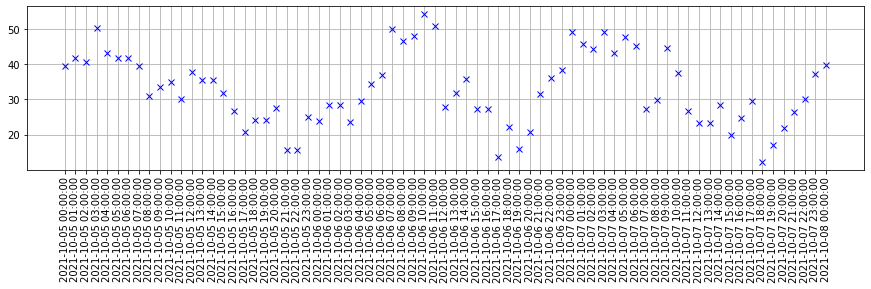

In [2]:
#The real period from which the data was obtained is from 01/03/2020 till 03/03/2020, and the reference station is the codigoSerial=90
start_time ="2021-10-05 00:00:00"
end_time   ="2021-10-08 00:00:00"

header_SS=["Fecha_Hora","codigoSerial","pm25","calidad_pm25","pm10","calidad_pm10"]
datatypes_SS={"codigoSerial":np.uint16,"pm25":np.float32,"pm10":np.float32}
df_SS = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/Dataset for testing/Synthetic/"+"SS_Synthetic_2.csv", header=None,names=header_SS, usecols=header_SS , dtype=datatypes_SS,parse_dates=["Fecha_Hora"], 
            dayfirst=True)

df_SS["Time"] = [d.strftime('%Y-%m-%d %H:%M:%S') for d in df_SS['Fecha_Hora']]
plt.figure(figsize=(15,3))
#plt.plot(df_SS["pm25"],"bx")
plt.plot(df_SS["Time"],df_SS["pm25"],"bx")
plt.xticks(rotation=90)
plt.grid()

DATA FOR THE CITIZEN NODE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Empty DataFrame
Columns: [codigoSerial, fecha, hora, fechaHora, temperatura, humedad_relativa, pm1_df, pm10_df, pm25_df, pm1_nova, pm10_nova, pm25_nova, calidad_temperatura, calidad_humedad_relativa, calidad_pm1_df, calidad_pm10_df, calidad_pm25_df, calidad_pm1_nova, calidad_pm10_nova, calidad_pm25_nova]
Index: []
2021-10-05 00:00:00 2021-10-08 00:00:00 73
2021-10-05 00:00:00 2021-10-08 00:00:00 4321


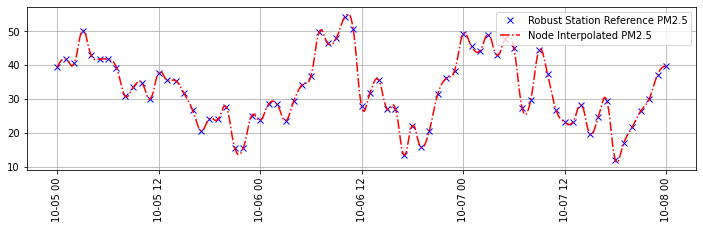

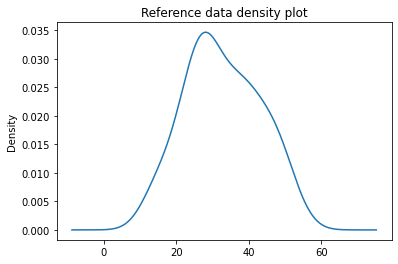

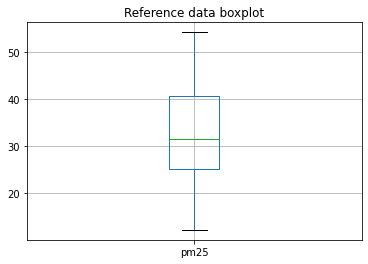

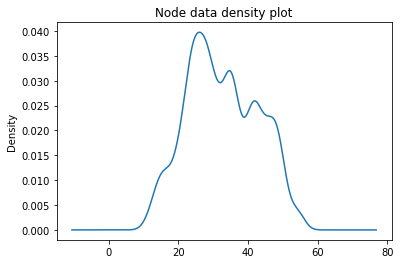

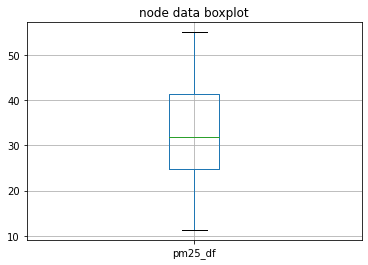

Amount of nan values:  0


In [50]:
header_CC=["codigoSerial", "fecha", "hora", "fechaHora", "temperatura", "humedad_relativa", "pm1_df", "pm10_df", "pm25_df", "pm1_nova", "pm10_nova", "pm25_nova", "calidad_temperatura", "calidad_humedad_relativa", "calidad_pm1_df", "calidad_pm10_df", "calidad_pm25_df", "calidad_pm1_nova", "calidad_pm10_nova", "calidad_pm25_nova"]
df_CC=pd.DataFrame(columns=header_CC)
print(df_CC)

#build a reference datetime column within the same period of the robust station
df_CC["fechaHora"] = pd.date_range(df_SS.Time.min(),(pd.to_datetime(df_SS.Time.max())+timedelta(minutes=0)).ceil('60min'), freq='1Min')
print(df_SS.Time.min(),df_SS.Time.max(),len(df_SS))
print(df_CC.fechaHora.min(),df_CC.fechaHora.max(),len(df_CC))

#Fill with same data from the robust station at every hour, other values will remail in nan
for d in df_SS['Time']:
    df_CC.loc[df_CC.fechaHora==d,"pm25"]=df_SS.loc[df_SS.Fecha_Hora==d,"pm25"].values[0]
    #print(df_CC.loc[df_CC.fechaHora==d,"Time"], df_CC.loc[df_CC.fechaHora==d,"pm25_df"])

df_CC.sort_values(by="fechaHora", axis=0, ascending=True, inplace=False, ignore_index=True)

# interpoate the missing values using the spiline method in order 3.
df_CC["pm25_df"]=df_CC.pm25.interpolate(method='polynomial', axis=0, order=2)



#Plot both not interpolated and interpolated data 

plt.figure(figsize=(12,3))
df_CC_aux=df_CC.loc[:,["fechaHora","pm25"]]
df_CC_aux=df_CC_aux.set_index("fechaHora",inplace=False)
plt.plot(df_CC_aux,"bx",label="Robust Station Reference PM2.5")
df_CC_aux=df_CC.loc[:,["fechaHora","pm25_df"]]
df_CC_aux=df_CC_aux.set_index("fechaHora",inplace=False)
plt.plot(df_CC_aux,"r-.",label="Node Interpolated PM2.5")
plt.xticks(rotation=90)
plt.grid(which='both')
plt.legend(loc="upper right")
plt.savefig('C:/Users/julio/Downloads/BaseData.eps', format='eps',bbox_inches = "tight")


#Density and boxplot Of Reference Station
plt.figure()
df_CC["pm25"].plot.density()
plt.title("Reference data density plot")
plt.show()

df_CC.boxplot(["pm25"])
plt.title("Reference data boxplot")
plt.show()
#df_CC=df_CC.copy()

#Density and boxplot of a node
plt.figure()
df_CC["pm25_df"].plot.density()
plt.title("Node data density plot")
plt.show()
df_CC.boxplot(["pm25_df"])
plt.title("node data boxplot")
plt.show()
#df_CC=df_CC.copy()

##CLEANING
Q1 = df_CC['pm25_df'].quantile(0.25)
Q3 = df_CC['pm25_df'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df_CC.loc[df_CC["pm25_df"]>=Q3 + 1.5 *IQR,"pm25_df"]=np.nan
#
#plt.figure()
#df_CC["pm25_df"].plot.density()
#plt.show()
#df_CC.boxplot(["pm25_df"])
#plt.show()

#If any nan value is present, then it means that some data was cleaned from the dataset
print("Amount of nan values: ",np.count_nonzero(np.isnan(df_CC['pm25_df'])))
#print(df_CC.head(5))


Get a Sample from a real citizen node to build a model for the temperature and humidity variables based on the PM2.5 concentrations

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 1.0, 'Temperature vs relative humidity')

<Figure size 864x216 with 0 Axes>

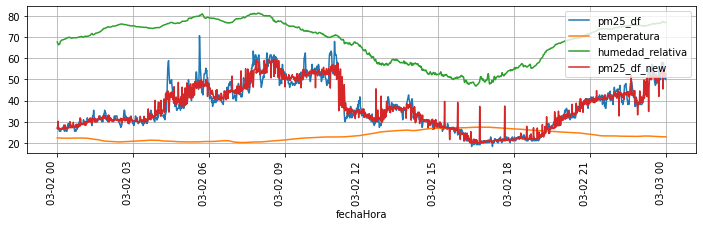

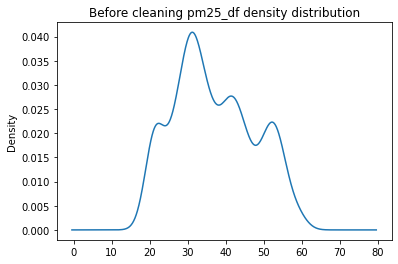

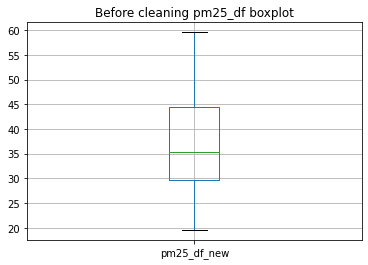

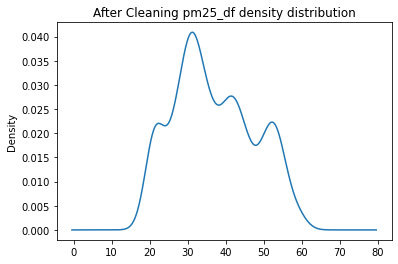

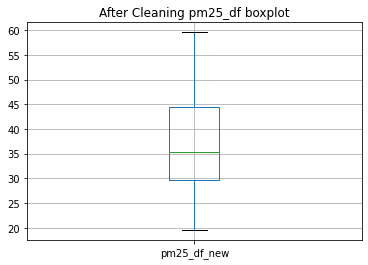

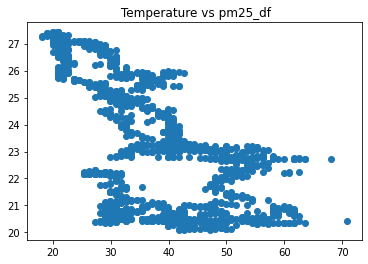

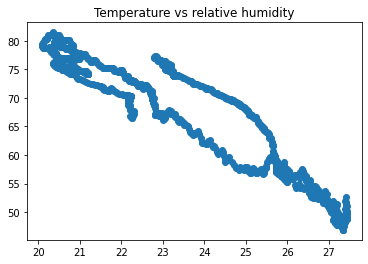

In [99]:
header_CC=["codigoSerial", "fecha", "hora", "fechaHora", "temperatura", "humedad_relativa", "pm1_df", "pm10_df", "pm25_df", "pm1_nova", "pm10_nova", "pm25_nova", "calidad_temperatura", "calidad_humedad_relativa", "calidad_pm1_df", "calidad_pm10_df", "calidad_pm25_df", "calidad_pm1_nova", "calidad_pm10_nova", "calidad_pm25_nova"]
datatypes_CC={"codigoSerial":np.uint16, "temperatura":np.float16, "humedad_relativa":np.float16, "pm1_df":np.float32, "pm10_df":np.float32, "pm25_df":np.float32, "pm1_nova":np.float32, "pm10_nova":np.float32, "pm25_nova":np.float32}
CC_data = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/Dataset for testing/Real/"+"CC_PM_March.csv", header=None, names=header_CC, usecols=header_CC , dtype=datatypes_CC,parse_dates=["fecha","hora","fechaHora"],dayfirst=True)

#get a one-day sample from the node with codigoSerial=67.
df_CC_CUT=CC_data.loc[(CC_data.codigoSerial==67) & (CC_data.fechaHora<="2020-03-03 00:00:00") & (CC_data.fechaHora>="2020-03-02 00:00:00"),][["codigoSerial","fechaHora","pm25_df","pm25_nova","temperatura","humedad_relativa"]]

df_CC_CUT=df_CC_CUT.reset_index()
df_CC_CUT.pop("index")

#See the behavior of the pm2.5 in this node at the chosen period
plt.figure(figsize=(12,3))
df_CC_aux=df_CC_CUT.loc[:,["fechaHora","pm25_df","temperatura","humedad_relativa"]]
df_CC_aux=df_CC_aux.set_index("fechaHora",inplace=False)
#print(df_CC_aux)
#plt.plot(df_CC_aux,"b-.",label="PM2.5 DF")

#df_CC_aux['pm25_df_new'] = df_CC_aux['pm25_df'].ewm(alpha=0.1).mean()
df_CC_aux['pm25_df_new'] = df_CC_aux['pm25_df'].rolling(window=10,center=True,min_periods=1).mean()
df_CC_aux.plot(figsize=(12,3))
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.grid()
plt.savefig('C:/Users/julio/Downloads/NodeForModel.eps', format='eps',bbox_inches = "tight")

df_CC_CUT['pm25_df_new'] = df_CC_CUT['pm25_df'].rolling(window=10,center=True,min_periods=1).mean()

#Density and boxplot before cleaning
plt.figure()
df_CC_CUT["pm25_df_new"].plot.density()
plt.title("Before cleaning pm25_df density distribution")
plt.figure()
df_CC_CUT.boxplot(["pm25_df_new"])
plt.title("Before cleaning pm25_df boxplot")

df_CC_CUT=df_CC_CUT.copy()

#CLEANING
Q1 = df_CC_CUT['pm25_df_new'].quantile(0.25)
Q3 = df_CC_CUT['pm25_df_new'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df_CC_CUT.loc[df_CC_CUT["pm25_df_new"]>=Q3 + 1.5 *IQR,"pm25_df_new"]=np.nan

plt.figure()
df_CC_CUT["pm25_df_new"].plot.density()
plt.title("After Cleaning pm25_df density distribution")
plt.figure()
df_CC_CUT.boxplot(["pm25_df_new"])
plt.title("After Cleaning pm25_df boxplot")

plt.figure()
plt.scatter(df_CC_CUT.pm25_df,df_CC_CUT.temperatura)
plt.title(" Temperature vs pm25_df")
plt.figure()
plt.scatter(df_CC_CUT.temperatura,df_CC_CUT.humedad_relativa)
plt.title("Temperature vs relative humidity")

POLYNOMIAL REGRESSION

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Coefficients for Temperature:  [[ 0.00000000e+00 -1.45860546e+00  3.02200415e-02 -2.15436793e-04]]
Intercept:  [46.1754617]
Coefficients for Humidity:  [[ 0.00000000e+00  3.99898137e+00 -6.26449915e-02  3.20317619e-04]]
Intercept:  [-7.27238877]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


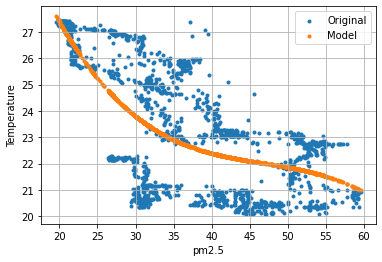

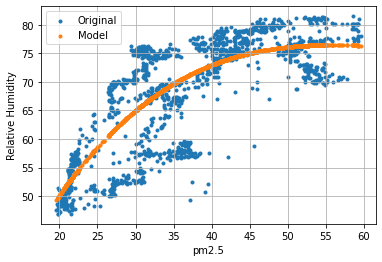

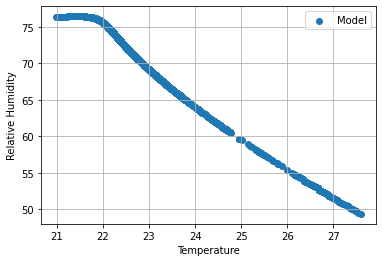

In [110]:
#Variables for the polynomial regression: get temperature in terms of the pm2.5
X = pd.DataFrame(df_CC_CUT["pm25_df_new"])
y = pd.DataFrame(df_CC_CUT["temperatura"])
#X = df_CC_CUT["pm25_df"]
#y = df_CC_CUT["temperatura"]
order=3
poly = PolynomialFeatures(degree = order)
X_poly = poly.fit_transform(X)
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)
model=lin2.fit(X_poly, y)
print("Coefficients for Temperature: ", model.coef_)
print("Intercept: ", model.intercept_)

#df_CC_CUT["temperatura3"]=lin2.predict(poly.fit_transform(X))
td=model.coef_[0][0] #0.0000000e+00
tc=model.coef_[0][1] #-1.3372504e+00
tb=model.coef_[0][2] #2.6521955e-02
ta=model.coef_[0][3] #-1.7845631e-04
taa=0*model.coef_[0][0] #-1.7845631e-04
te=model.intercept_[0] #44.785454

df_CC_CUT["temperatura2"]=taa*df_CC_CUT["pm25_df_new"]**4+ta*df_CC_CUT["pm25_df_new"]**3+tb*df_CC_CUT["pm25_df_new"]**2+tc*df_CC_CUT["pm25_df_new"]+td+te

plt.figure()
plt.scatter(df_CC_CUT.pm25_df_new,df_CC_CUT.temperatura,label="Original",marker=".")
plt.scatter(df_CC_CUT.pm25_df_new,df_CC_CUT.temperatura2,label="Model",marker=".")
#plt.scatter(df_CC_CUT.temperatura3,df_CC_CUT.pm25_df)
#plt.scatter(df_CC_CUT.temperatura4,df_CC_CUT.pm25_df)
#plt.title("Temperature vs pm25_df")
plt.xlabel("pm2.5")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.savefig('C:/Users/julio/Downloads/PM25vsTemperature.eps', format='eps',bbox_inches = "tight")

from sklearn.metrics import r2_score
y_true = pd.DataFrame(df_CC_CUT["temperatura"])
y_pred = pd.DataFrame(df_CC_CUT["temperatura2"])



#Variables for the polynomial regression: get relative humidity in terms of the pm2.5
X = pd.DataFrame(df_CC_CUT["pm25_df_new"])
y = pd.DataFrame(df_CC_CUT["humedad_relativa"])
#X=df_CC_CUT["pm25_df"]
#y=df_CC_CUT["humedad_relativa"]

poly = PolynomialFeatures(degree = order)
X_poly = poly.fit_transform(X)
 
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)
model=lin2.fit(X_poly, y)
print("Coefficients for Humidity: ", model.coef_)
print("Intercept: ", model.intercept_)
#df_CC_CUT["humedad_relativa3"]=lin2.predict(poly.fit_transform(X))

hd=model.coef_[0][0] #0.0000000e+00
hc=model.coef_[0][1] #4.4629354e+00
hb=model.coef_[0][2] #-7.4900344e-02
ha=model.coef_[0][3] #4.1961670e-04
haa=0*model.coef_[0][0] #4.1961670e-04
he=model.intercept_[0] #-12.343803

df_CC_CUT["humedad_relativa2"]=haa*df_CC_CUT["pm25_df_new"]**4+ha*df_CC_CUT["pm25_df_new"]**3+hb*df_CC_CUT["pm25_df_new"]**2+hc*df_CC_CUT["pm25_df_new"]+hd+he

plt.figure()
plt.scatter(df_CC_CUT.pm25_df_new,df_CC_CUT.humedad_relativa,label="Original",marker=".")
plt.scatter(df_CC_CUT.pm25_df_new,df_CC_CUT.humedad_relativa2,label="Model",marker=".")
#plt.scatter(df_CC_CUT.humedad_relativa3,df_CC_CUT.pm25_df)
#plt.scatter(df_CC_CUT.humedad_relativa4,df_CC_CUT.pm25_df)
#plt.title("Relative Humidity vs pm25_df")
plt.xlabel("pm2.5")
plt.ylabel("Relative Humidity")
plt.legend()
plt.grid()
plt.savefig('C:/Users/julio/Downloads/PM25vsHumidity.eps', format='eps',bbox_inches = "tight")

plt.figure()
plt.scatter(df_CC_CUT.temperatura2,df_CC_CUT.humedad_relativa2,label="Model")
#plt.title("Temperature vs Relative Humidity (from model)")
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.legend()
plt.grid()

In [111]:
#Get the r_square for both models
from sklearn.metrics import r2_score
y_true = pd.DataFrame(df_CC_CUT["temperatura"])
y_pred = pd.DataFrame(df_CC_CUT["temperatura2"])
print("r-squared temperature: ",r2_score(y_true, y_pred))

from sklearn.metrics import r2_score
y_true = pd.DataFrame(df_CC_CUT["humedad_relativa"])
y_pred = pd.DataFrame(df_CC_CUT["humedad_relativa2"])
print("r-squared humidity: ",r2_score(y_true, y_pred))

r-squared temperature:  0.4590509843063142
r-squared humidity:  0.6093661483518948


BASED ON THE POLYNOMIAL MODEL (Order 3, Then we get out final 3-days dataset as follows

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


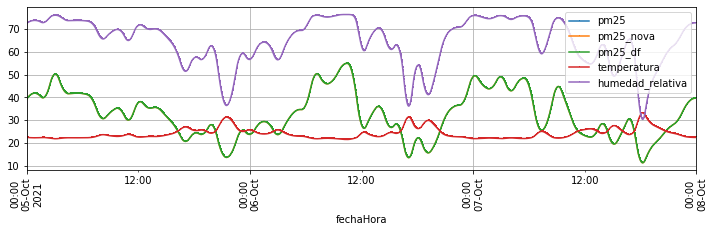

In [116]:
#Nova measurements set equal to df measurements
df_CC["pm25_nova"]=df_CC["pm25_df"]

#Temperature and humidity based on the models
df_CC["temperatura"]=         ta*df_CC["pm25_df"]**3  +  tb*df_CC["pm25_df"]**2  +  tc*df_CC["pm25_df"]  +  td  +  te
df_CC["humedad_relativa"]=    ha*df_CC["pm25_df"]**3  +  hb*df_CC["pm25_df"]**2  +  hc*df_CC["pm25_df"]  +  hd  +  he
#df_CC.pop("pm25")
df_CC["codigoSerial"]=67
#print(df_CC.tail(5))

#df_CC_aux=df_CC
df_CC_aux=df_CC.loc[:,["fechaHora","pm25","pm25_nova","pm25_df","temperatura","humedad_relativa"]]
df_CC_aux=df_CC_aux.set_index("fechaHora",inplace=False)
df_CC_aux.plot(figsize=(12,3),marker=",")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.grid()
plt.savefig('C:/Users/julio/Downloads/SyntheticDataset.eps', format='eps',bbox_inches = "tight")


AND WE CREATE 10 NODES WITH THE SAME INFORMATION (THIS CELL ALSO RESETS the CC DATASET TO REMOVE THE CHANGES ADDED IN THE EXPERIMENTS BELOW)

In [192]:
header_CC=["codigoSerial", "fecha", "hora", "fechaHora", "temperatura", "humedad_relativa", "pm1_df", "pm10_df","pm25", "pm25_df", "pm1_nova", "pm10_nova", "pm25_nova", "calidad_temperatura", "calidad_humedad_relativa", "calidad_pm1_df", "calidad_pm10_df", "calidad_pm25_df", "calidad_pm1_nova", "calidad_pm10_nova", "calidad_pm25_nova"]
CC=pd.DataFrame(columns=header_CC)
#10 nodes with the same data.
for node in range (1,11):
    #print(node)
    df_CC["codigoSerial"]=node
    CC=CC.append(df_CC, ignore_index = True)

Manually induce changed in the dataset to make the DQ change in each dimension

In [120]:
# ACCURACY: add an offset to the the df or nova measurements
Prop1=0.8
Prop2=1.2

CC["pm25_df"]=CC["pm25_df"]*Prop1
CC["pm25_nova"]=CC["pm25_nova"]*Prop2


In [194]:
# Completeness: randomly remove some data
Prop1=0.7
print(len(CC))
samples2remove=random.sample(range(len(CC)), round(Prop1*len(CC)))
print(len(samples2remove))
for i in samples2remove:
    CC.drop(i,axis='index',inplace=True)
print(len(CC))

43210
30247
12963


In [193]:
print(len(samples2remove))
print(len(CC))

30247
43210


In [89]:
# Data duplicates: randomly add some data
Prop1=0.5

samples2add=random.sample(range(len(CC)), round(Prop1*len(CC)))
for i in samples2add:
    CC=CC.append(CC.iloc[i], ignore_index = True)

In [13]:
# Data confidence: It will depend on mainly on the: 
#The p confidence level (usually set as 90, 95 and 99), Modified in the main code.
#The number of samples, and
#The stardard deviation.

Prop1=0 #for DF Standard deviation addded error
Prop2=0 #for NOVA Standard deviation addded error

hourly_groups=CC.groupby([CC.fechaHora.dt.floor('60min')])#Para agrupar por cada hora
i=0
for hour in hourly_groups.groups.keys():
    
    np.random.seed(i)
    i+=1
    window=hourly_groups.get_group(hour)
    #print(window)
    mean=window.pm25_df.mean()
    #print(hour, mean)
    
    
    indexes=(CC.fechaHora>=hour.floor('60min')) & (CC.fechaHora<(hour+timedelta(minutes=1)).ceil('60min'))
    #print(indexes)
    #print(len(CC.loc[indexes,"pm25_df"]))
    CC.loc[indexes,"pm25_df"]=  CC.loc[indexes,"pm25_df"]+  np.random.normal(0, Prop1*mean, size=len(CC.loc[indexes,"pm25_df"]))
    np.random.seed(i+1)
    CC.loc[indexes,"pm25_nova"]=CC.loc[indexes,"pm25_nova"]+np.random.normal(0, Prop2*mean, size=len(CC.loc[indexes,"pm25_nova"]))

Prop1=1#For completeness
#the number of samples.
samples2remove=random.sample(range(len(CC)), round(0.4*len(CC)))
#print(samples2remove)
for i in samples2remove:
    #print(i)
    CC.drop(i,axis='index',inplace=True)

In [139]:
# PRECISION: add random values.
Prop1=0.1 #for DF Standard deviation addded error
Prop2=0.2 #for NOVA Standard deviation addded error

hourly_groups=CC.groupby([CC.fechaHora.dt.floor('60min')])#Para agrupar por cada hora
i=0
for hour in hourly_groups.groups.keys():
    
    np.random.seed(i)
    i+=1
    window=hourly_groups.get_group(hour)
    #print(window)
    mean=window.pm25_df.mean()
    #print(hour, mean)
    
    
    indexes=(CC.fechaHora>=hour.floor('60min')) & (CC.fechaHora<(hour+timedelta(minutes=1)).ceil('60min'))
    #print(indexes)
    #print(len(CC.loc[indexes,"pm25_df"]))
    CC.loc[indexes,"pm25_df"]=  CC.loc[indexes,"pm25_df"]+  np.random.normal(0, Prop1*mean, size=len(CC.loc[indexes,"pm25_df"]))
    np.random.seed(i+1)
    CC.loc[indexes,"pm25_nova"]=CC.loc[indexes,"pm25_nova"]+np.random.normal(0, Prop2*mean, size=len(CC.loc[indexes,"pm25_nova"]))
    



In [ ]:
PLOT TO SEE THE CHANGES

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


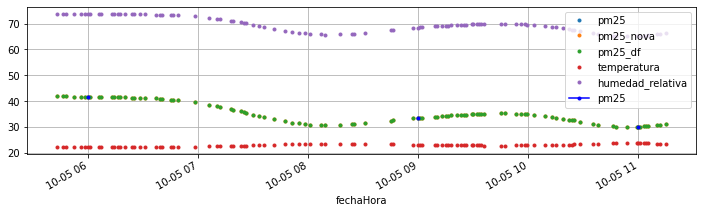

In [211]:
df_CC_aux=CC.loc[CC.codigoSerial==10,["fechaHora","pm25","pm25_nova","pm25_df","temperatura","humedad_relativa"]]
df_CC_aux=df_CC_aux.set_index("fechaHora",inplace=False)
df_CC_aux.iloc[100:200].plot(figsize=(12,3),marker=".",linestyle='none')#,marker=".",linestyle='none'
df_CC_aux.iloc[100:200].pm25.plot(marker=".", color="b")

plt.legend(loc="upper right")
plt.grid()
plt.savefig('C:/Users/julio/Downloads/SyntheticDataset_Completeness.eps', format='eps',bbox_inches = "tight")
plt.show()
#df_CC_aux

SAVE THE dataset

In [90]:
#Remove the pm25 column, it it not required and must not be included in the dataset
CC.pop("pm25")
CC.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/Dataset for testing/Synthetic/"+"CC_Synthetic2_.csv",header=False,index=False)

#Play a beeb when finish.
#win32api.Beep(2000, 100)